open the following link with a new tab


[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/nzhinusoftcm/review-on-collaborative-filtering/blob/master/8.PerformancesMeasure.ipynb)

In [1]:
import os

if not (os.path.exists("recsys.zip") or os.path.exists("recsys")):
    !wget https://github.com/nzhinusoftcm/review-on-collaborative-filtering/raw/master/recsys.zip    
    !unzip recsys.zip

### requirements

```
matplotlib==3.2.2
numpy==1.19.2
pandas==1.0.5
python==3.7
scikit-learn==0.24.1
scikit-surprise==1.1.1
scipy==1.6.2
```

In [2]:
from recsys.memories.UserToUser import UserToUser
from recsys.memories.ItemToItem import ItemToItem

from recsys.models.MatrixFactorization import MF
from recsys.models.ExplainableMF import EMF, explainable_score

from recsys.preprocessing import normalized_ratings
from recsys.preprocessing import train_test_split
from recsys.preprocessing import rating_matrix
from recsys.preprocessing import scale_ratings
from recsys.preprocessing import mean_ratings
from recsys.preprocessing import get_examples
from recsys.preprocessing import ids_encoder

from recsys.datasets import ml100k
from recsys.datasets import ml1m

from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import os

# 1. Results on MovieLens 100k

## 1.1. User-based CF

In [3]:
# load data
ratings, movies = ml100k.load()

# prepare data
ratings, uencoder, iencoder = ids_encoder(ratings)

# get examples as tuples of userids and itemids and labels from normalize ratings
raw_examples, raw_labels = get_examples(ratings, labels_column='rating')

# train test split
(x_train, x_test), (y_train, y_test) = train_test_split(examples=raw_examples, labels=raw_labels)

### Evaluation with the Euclidean distance

In [4]:
usertouser = UserToUser(ratings, movies, metric='euclidean')
print("==========================")
usertouser.evaluate(x_test, y_test)

Normalize users ratings ...
Initialize the similarity model ...
Compute nearest neighbors ...
User to user recommendation model created with success ...
Evaluate the model on 10000 test data ...

MAE : 0.8125945111976461


0.8125945111976461

### Evaluation with Cosine similarity

In [6]:
usertouser = UserToUser(ratings, movies, metric='cosine')
print("=========================")
usertouser.evaluate(x_test, y_test)

Normalize users ratings ...
Initialize the similarity model ...
Compute nearest neighbors ...
User to user recommendation model created with success ...
Evaluate the model on 10000 test data ...

MAE : 0.7505910931068639


0.7505910931068639

## 1.2. Item-based CF

In [7]:
# load data
ratings, movies = ml100k.load()

# prepare data
ratings, uencoder, iencoder = ids_encoder(ratings)

# get examples as tuples of userids and itemids and labels from normalize ratings
raw_examples, raw_labels = get_examples(ratings, labels_column='rating')

# train test split
(x_train, x_test), (y_train, y_test) = train_test_split(examples=raw_examples, labels=raw_labels)

### Evaluation with cosine similarity

In [9]:
itemtoitem = ItemToItem(ratings, movies, metric='cosine')
print("==================")
itemtoitem.evaluate(x_test, y_test)

Normalize ratings ...
Create the similarity model ...
Compute nearest neighbors ...
Item to item recommendation model created with success ...
Evaluate the model on 10000 test data ...

MAE : 0.507794195659005


0.507794195659005

### Evaluation with Euclidean distance

In [10]:
itemtoitem = ItemToItem(ratings, movies, metric='euclidean')
print("==================")
itemtoitem.evaluate(x_test, y_test)

Normalize ratings ...
Create the similarity model ...
Compute nearest neighbors ...
Item to item recommendation model created with success ...
Evaluate the model on 10000 test data ...

MAE : 0.8277111416143341


0.8277111416143341

## 1.3. Matrix Factorization

In [11]:
# load the ml100k dataset
ratings, movies = ml100k.load()

ratings, uencoder, iencoder = ids_encoder(ratings)

m = ratings.userid.nunique()   # total number of users
n = ratings.itemid.nunique()   # total number of items

# get examples as tuples of userids and itemids and labels from normalize ratings
raw_examples, raw_labels = get_examples(ratings)

# train test split
(x_train, x_test), (y_train, y_test) = train_test_split(examples=raw_examples, labels=raw_labels)

In [12]:
m = ratings['userid'].nunique()   # total number of users
n = ratings['itemid'].nunique()   # total number of items

# create and train the model
mf = MF(m, n, k=10, alpha=0.015, lamb=2)
mf_hist = mf.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

Training Matrix Factorization Model ...
k=10 	 alpha=0.015 	 lambda=2
epoch 1/10 - loss : 0.83 - val_loss : 0.831
epoch 2/10 - loss : 0.827 - val_loss : 0.828
epoch 3/10 - loss : 0.826 - val_loss : 0.827
epoch 4/10 - loss : 0.826 - val_loss : 0.827
epoch 5/10 - loss : 0.826 - val_loss : 0.827
epoch 6/10 - loss : 0.826 - val_loss : 0.827
epoch 7/10 - loss : 0.826 - val_loss : 0.827
epoch 8/10 - loss : 0.826 - val_loss : 0.827
epoch 9/10 - loss : 0.826 - val_loss : 0.827
epoch 10/10 - loss : 0.826 - val_loss : 0.827


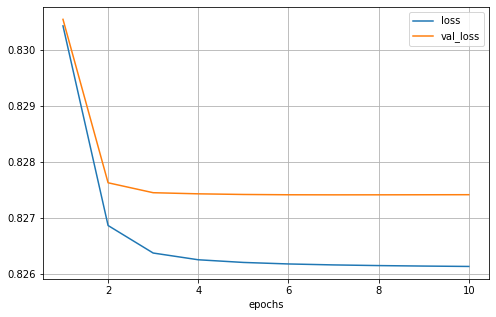

In [13]:
pd.DataFrame(mf_hist).plot(x="epochs", figsize=(8, 5))
plt.grid(True)
plt.show()

In [14]:
mf.evaluate(X_test, y_test)

validation error : 0.827


0.8274155323406809

## 1.4. Explainable Matrix Factorization

In [25]:
# load data
ratings, movies = ml100k.load()

# create the user to user model for similarity measure
usertouser = UserToUser(ratings, movies)

# normalize ratings by substracting means
normalized_column_name = "norm_rating"
ratings = normalized_ratings(ratings, norm_column=normalized_column_name)

# scale rating
scaled_column_name = "scaled_rating"
ratings = scale_ratings(ratings, scaled_column=scaled_column_name)

# get examples as tuples of userids and itemids and labels from normalize ratings
raw_examples, raw_labels = get_examples(ratings, labels_column=normalized_column_name)

# train test split
(train_examples, test_examples), (train_labels, test_labels) = split_data(examples=raw_examples, labels=raw_labels)

examples = (train_examples, test_examples)
labels = (train_labels, test_labels)

# encode train and test examples
(X_train, X_test), (y_train, y_test), (uencoder, iencoder) = encode_data( ratings, examples = examples, labels = labels)

Normalize users ratings ...
Create the similarity model ...
Compute nearest neighbors ...
User to user recommendation model created with success ...
Train/Test split 
90.0 % of training data
10.0 % of testing data

number of training examples :  (90000, 2)
number of training labels :  (90000,)
number of test examples :  (10000, 2)
number of test labels :  (10000,)


In [26]:
users = sorted(ratings['userid'].unique())
items = sorted(ratings['itemid'].unique())

m = len(users)
n = len(items)

# compute explainable scores
W = explainable_score(usertouser, users, items, uencoder, iencoder)

Compute explainable scores ...


In [28]:
# create, train and evaluate the EMF model
emf = EMF(m, n, W, alpha=0.01, beta=0.4, lamb=0.01, k=10)

emf_hist = emf.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

Training EMF
k=10 	 alpha=0.01 	 beta=0.4 	 lambda=0.01
epoch 1/10 - loss : 0.835 - val_loss : 0.888
epoch 2/10 - loss : 0.804 - val_loss : 0.849
epoch 3/10 - loss : 0.796 - val_loss : 0.835
epoch 4/10 - loss : 0.789 - val_loss : 0.824
epoch 5/10 - loss : 0.779 - val_loss : 0.812
epoch 6/10 - loss : 0.768 - val_loss : 0.799
epoch 7/10 - loss : 0.757 - val_loss : 0.787
epoch 8/10 - loss : 0.75 - val_loss : 0.778
epoch 9/10 - loss : 0.744 - val_loss : 0.772
epoch 10/10 - loss : 0.74 - val_loss : 0.767


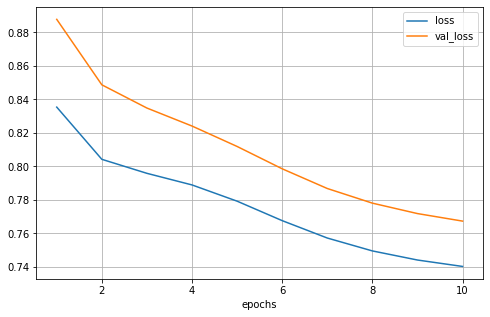

In [29]:
pd.DataFrame(emf_hist).plot(x="epochs", figsize=(8, 5))
plt.grid(True)
plt.show()

In [30]:
emf.evaluate(X_test, y_test)

validation error : 0.767


0.7673674134065074

# 3. Results on MovieLens 1M (ML-1M)

## 3.1. User-based CF

In [11]:
# load ml100k ratings
ratings, movies = ml1m.load()

# prepare data
ratings, uencoder, iencoder = ids_encoder(ratings)

# get examples as tuples of userids and itemids and labels from normalize ratings
raw_examples, raw_labels = get_examples(ratings, labels_column='rating')

# train test split
(x_train, x_test), (y_train, y_test) = train_test_split(examples=raw_examples, labels=raw_labels)

### Cosine similarity

In [12]:
# create the user-based CF
usertouser = UserToUser(ratings, movies, k=20, metric='cosine')

# evaluate the user-based CF on the ml1m test data
print("==========================")
usertouser.evaluate(x_test, y_test)

Normalize users ratings ...
Initialize the similarity model ...
Compute nearest neighbors ...
User to user recommendation model created with success ...
Evaluate the model on 100021 test data ...

MAE : 0.732267005840993


0.732267005840993

### Euclidean distance

In [13]:
# create the user-based CF
usertouser = UserToUser(ratings, movies, k=20, metric='euclidean')

# evaluate the user-based CF on the ml1m test data
print("==========================")
usertouser.evaluate(x_test, y_test)

Normalize users ratings ...
Initialize the similarity model ...
Compute nearest neighbors ...
User to user recommendation model created with success ...
Evaluate the model on 100021 test data ...

MAE : 0.8069332535426615


0.8069332535426615

## 3.2. Item-based CF

### Cosine similarity

In [15]:
itemtoitem = ItemToItem(ratings, movies, metric='cosine')
print("==========================")
itemtoitem.evaluate(x_test, y_test)

Normalize ratings ...
Create the similarity model ...
Compute nearest neighbors ...
Item to item recommendation model created with success ...
Evaluate the model on 100021 test data ...

MAE : 0.42514728655396045


0.42514728655396045

### Euclidean distance

In [14]:
itemtoitem = ItemToItem(ratings, movies, metric='euclidean')
print("==========================")
itemtoitem.evaluate(x_test, y_test)

Normalize ratings ...
Create the similarity model ...
Compute nearest neighbors ...
Item to item recommendation model created with success ...
Evaluate the model on 100021 test data ...

MAE : 0.82502173206615


0.82502173206615

## 3.3. Matrix Factorization

In [7]:
# load data
ratings, movies = ml1m.load()

# normalize ratings by substracting means
normalized_column_name = "norm_rating"
ratings = normalized_ratings(ratings, norm_column=normalized_column_name)

# get examples as tuples of userids and itemids and labels from normalize ratings
raw_examples, raw_labels = get_examples(ratings, labels_column=normalized_column_name)

# train test split
(train_examples, test_examples), (train_labels, test_labels) = split_data(examples=raw_examples, labels=raw_labels)

examples = (train_examples, test_examples)
labels = (train_labels, test_labels)

# encode train and test examples
(X_train, X_test), (y_train, y_test), (uencoder, iencoder) = encode_data( ratings, examples = examples, labels = labels)

In [ ]:
m = ratings['userid'].nunique()   # total number of users
n = ratings['itemid'].nunique()   # total number of items

# create and train the model
mf = MF(m, n, k=10, alpha=0.01, lamb=1.5)
history = mf.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

## 3.4. Explainable Matrix Factorization

In [ ]:
# load data
ratings, movies = ml1m.load()

# create the user to user model for similarity measure
usertouser = UserToUser(ratings, movies)

# normalize ratings by substracting means
normalized_column_name = "norm_rating"
ratings = normalized_ratings(ratings, norm_column=normalized_column_name)

# scale rating
scaled_column_name = "scaled_rating"
ratings = scale_ratings(ratings, scaled_column=scaled_column_name)

# get examples as tuples of userids and itemids and labels from normalize ratings
raw_examples, raw_labels = get_examples(ratings, labels_column=normalized_column_name)

# train test split
(train_examples, test_examples), (train_labels, test_labels) = split_data(examples=raw_examples, labels=raw_labels)

examples = (train_examples, test_examples)
labels = (train_labels, test_labels)

# encode train and test examples
(X_train, X_test), (y_train, y_test), (uencoder, iencoder) = encode_data( ratings, examples = examples, labels = labels)

In [ ]:
users = sorted(ratings['userid'].unique())
items = sorted(ratings['itemid'].unique())

m = len(users)
n = len(items)

# compute explainable scores
W = explainable_score(usertouser, users, items, uencoder, iencoder)

In [ ]:
# create, train and evaluate the EMF model
emf = EMF(m, n, W, alpha=0.01, beta=0.4, lamb=0.01, k=10)

emf_hist = emf.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

## Author

[Carmel WENGA](https://www.linkedin.com/in/carmel-wenga-871876178/), <br>
PhD student at Université de la Polynésie Française, <br> 
Applied Machine Learning Research Engineer, <br>
[ShoppingList](https://shoppinglist.cm), NzhinuSoft.